In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from susy_tools import *
import multiprocessing as mp

In [2]:
mu = 1000
tanB = 10
m_sleptons = 1000

## Edit susy-hit input to generate spectra
changeParamValue("mu(EWSB)", mu)
changeParamValue("A_t", 3.50e3)
changeParamValue("A_tau", -250)
changeParamValue("tanbeta(MZ)", tanB)

changeParamValue("M_eL",   m_sleptons)
changeParamValue("M_eR",   m_sleptons)
changeParamValue("M_muL",  m_sleptons)
changeParamValue("M_muR",  m_sleptons)
changeParamValue("M_tauL", m_sleptons)
changeParamValue("M_tauR", m_sleptons)

#optimize_higgs(125, 0.5)

In [3]:
compressed = True

points = []

N = (5, 5)
max_diff = 80.
M2 = 125.
max_sleptonmass = 4000
randomness = 0.0

m_sleptons = np.logspace(np.log10(M2+150), np.log10(max_sleptonmass), N[0])

def command(m1, m2, index):
    #print(m_in[index])
    changeParamValue("M_eL",   m_sleptons[index])
    changeParamValue("M_eR",   m_sleptons[index])
    changeParamValue("M_muL",  m_sleptons[index])
    changeParamValue("M_muR",  m_sleptons[index])
    changeParamValue("M_tauL", m_sleptons[index])
    changeParamValue("M_tauR", m_sleptons[index])
    changeParamValue("mu(EWSB)", m_sleptons[index])

    
points_l = []

for i,m in enumerate(m_sleptons):
    
    command(1, 1, i)
    
    M1_0 = get_closestmass(M2)
    M1_max = M2 / M1_0 * M2
    
    points = []
    points.append([M1_max, M2])
    #for dm in np.logspace(np.log10(max_diff) / N[1], np.log10(max_diff), N[1]-1):
    for dm in np.linspace(max_diff/N[1], max_diff, N[1]-1):
        points.append([M1_max - dm, M2])
    
    points_l.append(points)

In [17]:
br_Z = []
br_h = []
br_stau = []
br_emu = []
br_snu = []
br_nu = []
br_gam = []
br_x0_quarks = []
br_xpm_quarks = []
br_sleptons = []
br_stau = []
h_m = []

m_x1 = []
m_x2 = []
gm2 = []
om = []

for i, m_s in enumerate(m_sleptons):
    
    command(0,0,i)
    
    queue = run(points_l[i], True, run_prospino=False, run_micromegas=True,
        working_directory="br_dir")

    if queue.qsize() > 0:
        data = []
        while queue.qsize() > 0:
            ret = queue.get()
            data.append([ret[i] for i in ["M1", "M2", "m_x1", "m_x2", "gm2", "omega"]])

    
    for line in data:
        filename = "spectrum_%i_%i.dat" % (line[0], line[1])

        with open("./br_dir/spectra_slha/" + filename) as f:
            s = f.read()
        
        
        m_x1.append(line[2])
        m_x2.append(line[3])
        gm2.append(line[4])
        om.append(line[5])
            
        br_Z.append(np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10   Z )")))
        br_h.append(np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10   h )")))

        br_sleptons.append(getBranchingRatio(s, "BR(~chi_20 -> ~mu_L-    mu+)") + 
                      getBranchingRatio(s, "BR(~chi_20 -> ~mu_L+    mu-)") +
                      getBranchingRatio(s, "BR(~chi_20 -> ~e_L-     e+)") +
                      getBranchingRatio(s, "BR(~chi_20 -> ~e_L+     e-)") +
                      getBranchingRatio(s, "BR(~chi_20 -> ~tau_1+   tau-)") +
                      getBranchingRatio(s, "BR(~chi_20 -> ~tau_1-   tau+)") )

        br_emu.append(np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 e+      e-)")) + 
                      np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 mu+     mu-)")) )
        
        br_stau.append(np.nan_to_num(np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 tau+    tau-)"))))

        br_snu.append(2 * getBranchingRatio(s, "BR(~chi_20 -> ~nu_eL*   nu_e ") + 
                      2 * getBranchingRatio(s, "BR(~chi_20 -> ~nu_muL*  nu_mu ") + 
                      2 * getBranchingRatio(s, "BR(~chi_20 -> ~nu_tau1* nu_tau "))

        br_nu.append(np.nan_to_num(3*getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 nu_eb   nu_e)")))

        br_x0_quarks.append(np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 ub      u)")) +
                         np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 db      d)")) +
                         np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 cb      c)")) +
                         np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 sb      s)")) +
                         np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 bb      b)")) 
                        )

        br_gam.append(np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_10 gam)")))

        br_xpm_quarks.append(np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_1+ ub      d)")) +
                             np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_1- db      u)")) +
                             np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_1+ cb      s)")) +
                             np.nan_to_num(getBranchingRatio(s, "BR(~chi_20 -> ~chi_1- sb      c)"))
                            )

        h_m.append(getParamValue(s, "h"))

Running 20 points... 
Running 20 points...  Runtime: 0:00:05 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:05 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:06 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:06 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:06 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:05 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:06 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:05 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:05 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:06 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:06 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:05 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:05 	 Time Remaining (est): 0:00:00 
Running 20 points...  Runtime: 0:00:05 	 T

In [18]:
def plot_z_h(x, compressed=False):
    if not compressed:
        plt.plot(x, x-92.)
        plt.plot(x, x-125.)
    else:
        plt.plot(x, len(x)*[92.])
        plt.plot(x, len(x)*[125.])

In [19]:
bz = np.array(br_Z)
bh = np.array(br_h)

bz[np.isnan(bz)] = 0
bh[np.isnan(bh)] = 0
br_hz = bz + bh

m_x1 = np.array(m_x1)
m_x2 = np.array(m_x2)

if compressed:
    y = m_x2 - m_x1
else:
    y = m_x1
    
x = np.array([a for a in m_sleptons for b in range(N[1])])

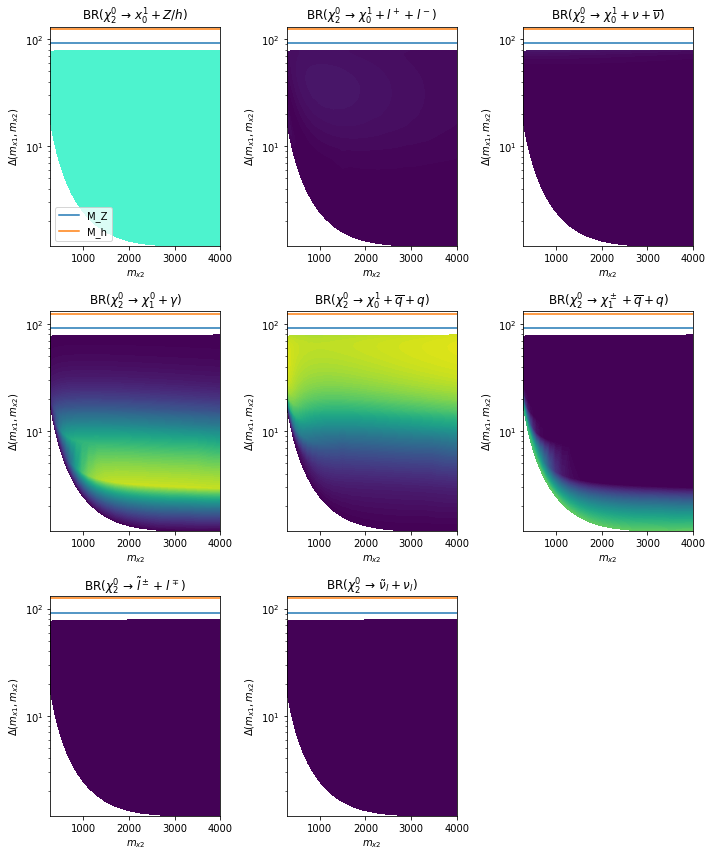

In [20]:
h_cmap = truncate_colormap(plt.get_cmap("rainbow"), 0.4, 1)
z_cmap = truncate_colormap(plt.get_cmap("PRGn_r"), 0.4, 1)

levels = np.linspace(0, 1.001, 100)

f = plt.figure(figsize=(10,12))
    
    
br_rat = [br_hz,  br_emu, br_nu, br_gam, br_x0_quarks, br_xpm_quarks, br_sleptons, br_snu]
cmaps = [h_cmap, "viridis", "viridis", "viridis", "viridis", "viridis", "viridis", "viridis"]
names = ["$x_0^1 + Z/h$",  "$\chi_0^1 + l^+ + l^-$", r"$\chi_0^1 + \nu + \overline{\nu}$", "$\chi_1^0 + \gamma$", 
         "$\chi_0^1 + \overline{q} + q$", "$\chi_1^\pm + \overline{q} + q$", "$\~l^\pm + l^\mp$",
         r"$\~{\nu}_l + \nu_l$"]

    
for i in range(len(br_rat)):

    ax = f.add_subplot(3, 3, i+1)

    br_rat_nonan = np.array(br_rat[i])
    br_rat_nonan[np.isnan(br_rat_nonan[i])] = 0
    
    xl = np.linspace(min(x), max(x), 10)

    zp = plt.plot(xl, len(xl)*[92.])
    hp = plt.plot(xl, len(xl)*[125.])
    ax.tricontourf(x, y, np.ones(len(y)), cmap="gray_r", alpha=0.1)

    z = np.ones(len(y))
    mi = np.argmin(x**2 + y**2)
    z[mi] = -1
    
    ax.tricontourf(x, y, br_rat_nonan,levels=levels, cmap=cmaps[i])

    lims = plt.ylim()
    xlims = plt.xlim()
    #plt.fill_between([xlims[0], xlims[1]], [xlims[0] - m_sleptons, xlims[1] - m_sleptons],
    #                hatch="x", color="gray", alpha=0.5)
    plt.ylim(*lims)

    plt.xlabel(r"$m_{x2}$")
    plt.ylabel(r"$\Delta(m_{x1}, m_{x2})$")
    plt.title(r"BR$(\chi_2^0\  \to $ % s)" % names[i])
    plt.yscale("log")
    
    if i == 0:

        plt.legend([zp[0], hp[0]],["M_Z", "M_h"])
        #plt.text(1500, 30, "tanB: %i\nmu: %i\nM2: %i" % (tanB, mu, M2))

plt.tight_layout()

<ipython-input-24-c9e729e85f6c>:63: UserWarning: The following kwargs were not used by contour: 'linestyle'
  lim = ax.tricontour(x, y, np.vstack(points_l).T[0] - np.vstack(points_l).T[1],


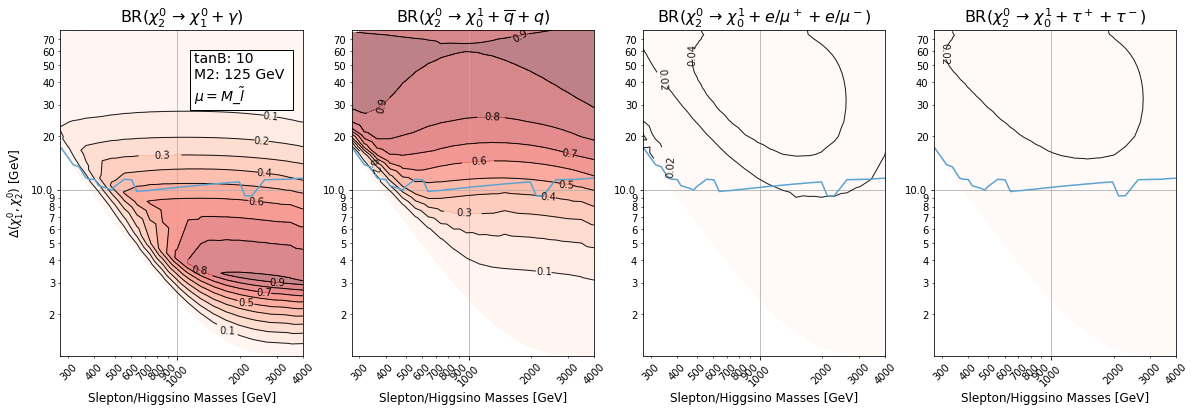

In [24]:
import matplotlib
h_cmap = truncate_colormap(plt.get_cmap("rainbow"), 0.4, 1)
z_cmap = truncate_colormap(plt.get_cmap("PRGn_r"), 0.4, 1)

levels = np.linspace(0, 1.001, 100)

f = plt.figure(figsize=(20, 6))

show_omega=False
    
br_rat = [br_gam, br_x0_quarks, br_emu, br_stau] #, br_nu]
    
names = [ "$\chi_1^0 + \gamma$", "$\chi_0^1 + \overline{q} + q$", "$\chi_0^1 + e/\mu^+ + e/\mu^-$", r"$\chi_0^1 + \tau^+ + \tau^-$"]

n_levels = 10
levels_l = [np.linspace(0,1, n_levels+1),
            np.linspace(0,1, n_levels+1),
            np.append(np.linspace(0,0.2, n_levels+1), 1),
            np.append(np.linspace(0,0.2, n_levels+1), 1),
           ]

max_br = np.max(np.array(br_rat)[~np.isnan(br_rat)])
for i in range(len(br_rat)):

    ax = f.add_subplot(1, 4, i+1)
    
    br_nonan = np.array(br_rat[i])
    br_nonan[np.isnan(br_nonan)] = 0
    
    N_levels = 7

    
    #levels = np.array([0, 0.01] + list(np.linspace(0.1,1.01,N_levels-1))) * max(br_nonan)
    
    
    #levels = np.logspace(np.log10(min(br_nonan[br_nonan != 0])),
    #                        np.log10(max(br_nonan)),
    #                        10)
    
    #levels = np.linspace(min(br_nonan[br_nonan != 0]),
    #                     max(br_nonan)*1.05, N_levels)
    
    mx = max(br_nonan)
    mn = 0.01*min(br_nonan[br_nonan != 0])
    
    #levels = (1.015*mx - (mx-mn) * np.logspace(-2, 0, N_levels))[::-1]
    levels = levels_l[i]
    
    cmap_br = truncate_colormap(plt.get_cmap("Reds"), 0, mx/max_br)
    
    cs = ax.tricontourf(x,y, br_nonan, levels=levels, 
                    alpha=0.5, cmap=cmap_br)
    

    cmapblack = truncate_colormap(plt.get_cmap("Greys"), 0.9, 1)
    cs = ax.tricontour(x,y, br_nonan, levels=levels,
                      cmap=cmapblack, linewidths=1)

    ax.clabel(cs, cs.levels, inline=True, fontsize=10)
    
    
    cmap = truncate_colormap(plt.get_cmap("Blues"), 0.4, 0.55)
    lim = ax.tricontour(x, y, np.vstack(points_l).T[0] - np.vstack(points_l).T[1], 
                        levels= [-M2, 0], cmap=cmap)

    ax.set_xlabel(r"Slepton/Higgsino Masses [GeV]", fontsize=12)
    ax.set_title(r"BR$(\chi_2^0\  \to $ %s)" % names[i], fontsize=16)
    ax.set_yscale("log")
    ax.set_xscale("log")

    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())

    ax.tick_params(axis="x", which="both", rotation=45)
    #for tick in ax.get_xticklabels():
    #    tick.set_rotation(45)
    
    ax.grid(1)
    
    if show_omega:
    
        ax.tricontourf(x, y, om, levels=[0.1, 0.5], cmap="Greens", alpha=0.8)
        
        ax.tricontourf(x,y, gm2, levels=[1e-9, 4e-9], cmap="Purples", alpha=0.7)
    
    if i == 0:
        pass

        ax.set_ylabel(r"$\Delta(\chi_1^0, \chi_2^0)$ [GeV]", fontsize=12)

        plt.text(np.max(m_sleptons)*0.3, ax.get_ylim()[1]*0.4, "tanB: %i\nM2: %i GeV \n"% (tanB, M2) + r"$\mu = M\_\~l$" , 
                 fontsize=14, bbox=dict(facecolor='white', edgecolor='black',))
        
        plt.plot()
        
plt.savefig("BranchingRatios_tanB_%i_M2_%i.pdf" % (tanB, M2))
#plt.colorbar(plt.contourf([0,1],[0,1],[[0,0],[1,1]], np.linspace(0,1,11), cmap = "Reds"))
#plt.tight_layout()

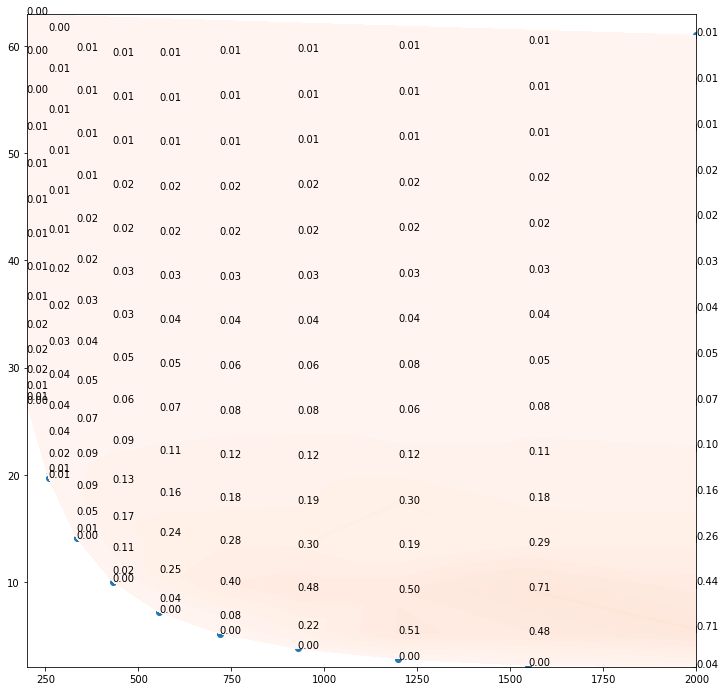

In [314]:
plt.figure(figsize=(12,12))
plt.scatter(x, y)
plt.tricontourf(x,y,br_gam,cmap=cmap_br)
for i in range(len(x)):
    
    plt.text(x[i], y[i], "%.2f" % br_gam[i])

In [315]:
m_sleptons

array([ 200.        ,  258.309933  ,  333.62010744,  430.88693801,
        556.51188044,  718.76273276,  928.31776672, 1198.96850064,
       1548.52736536, 2000.        ])

In [316]:
command(0,0,5)

In [317]:
get_closestmass(105.5)

99.8653336313702

In [318]:
get_neutralinoMassDiff(97.22, 99.86)

9.716726499999993

In [319]:
for i in range(len(x)):
    print("%.1f, %.1f" % (x[i], y[i]), np.vstack(points_l)[i], br_gam[i])

200.0, 26.7 [ 85.47128565 100.        ] 0.00413050117
200.0, 27.1 [ 81.47128565 100.        ] 0.00671475208
200.0, 28.0 [ 77.16359334 100.        ] 0.0109049739
200.0, 29.5 [ 72.85590103 100.        ] 0.0153750818
200.0, 31.5 [ 68.54820873 100.        ] 0.0176108222
200.0, 33.8 [ 64.24051642 100.        ] 0.0168759811
200.0, 36.4 [ 59.93282411 100.        ] 0.0146057349
200.0, 39.2 [ 55.6251318 100.       ] 0.0120955815
200.0, 42.3 [ 51.3174395 100.       ] 0.00986766873
200.0, 45.4 [ 47.00974719 100.        ] 0.00802990966
200.0, 48.8 [ 42.70205488 100.        ] 0.00655152315
200.0, 52.2 [ 38.39436257 100.        ] 0.00537117655
200.0, 55.7 [ 34.08667026 100.        ] 0.00443030484
200.0, 59.3 [ 29.77897796 100.        ] 0.00368115354
200.0, 62.9 [ 25.47128565 100.        ] 0.00308741429
258.3, 19.7 [ 93.10750596 100.        ] 0.00538335737
258.3, 20.3 [ 89.10750596 100.        ] 0.0115778434
258.3, 21.7 [ 84.79981365 100.        ] 0.0249344893
258.3, 23.7 [ 80.49212134 100.        ] 

In [224]:
points_f

[[106.49998345442685, 100],
 [94.49998345442685, 100],
 [78.49998345442685, 100],
 [62.499983454426854, 100],
 [46.499983454426854, 100],
 [106.49998345442685, 100],
 [94.49998345442685, 100],
 [78.49998345442685, 100],
 [62.499983454426854, 100],
 [46.499983454426854, 100],
 [106.49998345442685, 100],
 [94.49998345442685, 100],
 [78.49998345442685, 100],
 [62.499983454426854, 100],
 [46.499983454426854, 100],
 [106.49998345442685, 100],
 [94.49998345442685, 100],
 [78.49998345442685, 100],
 [62.499983454426854, 100],
 [46.499983454426854, 100],
 [106.49998345442685, 100],
 [94.49998345442685, 100],
 [78.49998345442685, 100],
 [62.499983454426854, 100],
 [46.499983454426854, 100]]

In [153]:
get_neutralinoMassDiff(107, 100)

1.8138139999999936

In [149]:
mx - (mx-mn) * np.logspace(-2, 0, N_levels)


array([0.91122624, 0.90485566, 0.88471013, 0.82100435, 0.61954899])

In [150]:
mn

0.6195489912000001

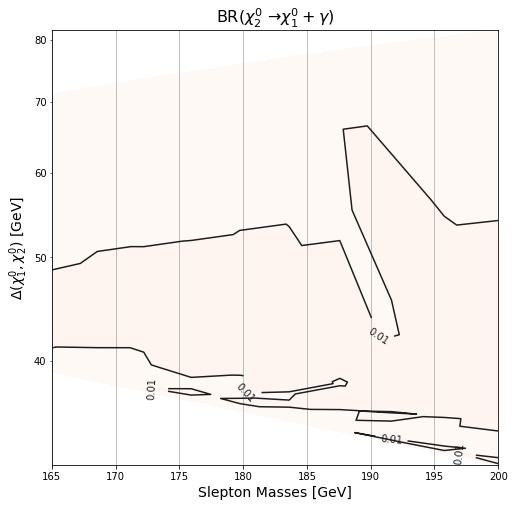

In [31]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)

x = np.array(m_sleptons_f)
y = m_x2 - m_x1

sel = ~np.isnan(br_gam)
    
br_gam_nonan = np.array(br_gam)
br_gam_nonan[~sel] = 0

#plt.tricontourf(x, y, np.ones(len(y)), cmap="gray_r", alpha=0.1)

cs = ax.tricontourf(x,y, br_gam_nonan, levels=[0, 0.01] + list(np.linspace(0.1,1,10)), 
                    alpha=0.5, cmap="Reds")

cmapblack = truncate_colormap(plt.get_cmap("Greys"), 0.9, 1)
cs = ax.tricontour(x,y, br_gam_nonan, levels=[0,e 0.01] + list(np.linspace(0.1,1,10)),
                  cmap=cmapblack)


ax.clabel(cs, cs.levels, inline=True, fontsize=10)

ax.set_xlabel(r"Slepton Masses [GeV]", fontsize=14)
ax.set_ylabel(r"$\Delta(\chi_1^0, \chi_2^0)$ [GeV]", fontsize=14)
ax.set_title(r"BR$(\chi_2^0\  \to \chi_1^0 + \gamma $)", fontsize=16)
ax.set_yscale("log")

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax.grid(1)

In [152]:
cs

In [128]:
A = np.logspace(3, 4, 20)

h = [get_higgs(a) for a in A]

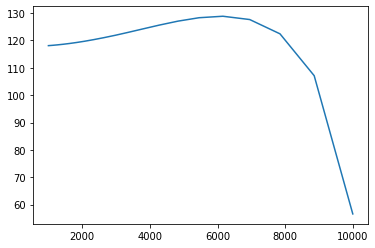

In [130]:
plt.plot(A, h)

In [196]:
br_rat_nonan = np.array(br_rat)
br_rat_nonan[np.isnan(br_rat_nonan)] = 0
tot = np.sum(br_rat_nonan, axis=0)

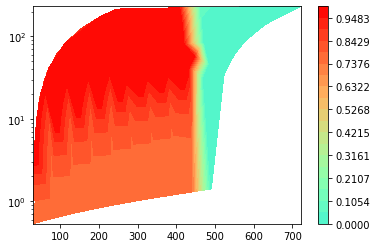

In [152]:
plt.tricontourf(m_x2, y, 
                tot,levels=np.linspace(0, 1.001, 20), cmap=cmaps[0])
plt.colorbar()
plt.yscale("log")

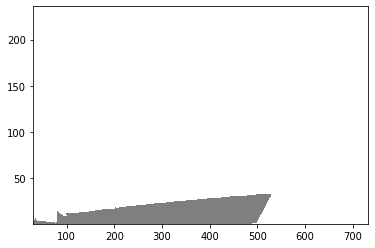

In [134]:
M_diff = np.array(points).T[1] - np.array(points).T[0]



In [125]:
M_diff

array([ -2.48017241,   0.5326496 ,   1.11754535,   2.34470766,
         4.9194013 ,  10.32133325,  21.6550579 ,  45.43420132,
        95.32491943, 200.        ,  -7.27118675,   0.6218337 ,
         1.27965743,   2.63337792,   5.41916853,  11.15198368,
        22.94941359,  47.2270763 ,  97.18752626, 200.        ,
       -11.3730613 ,   0.711842  ,   1.44033796,   2.91437347,
         5.89693042,  11.931823  ,  24.14279799,  48.8504309 ,
        98.84374629, 200.        , -14.98935023,   0.803668  ,
         1.60166189,   3.19201561,   6.36149472,  12.67807556,
        25.26664048,  50.35489165, 100.35426413, 200.        ,
       -18.22722913,   0.89751   ,   1.76416066,   3.46766369,
         6.81609773,  13.39783565,  26.33500974,  51.76453544,
       101.7492363 , 200.        , -21.15557555,   0.993778  ,
         1.92866569,   3.74304055,   7.26427221,  14.09807079,
        27.36070377,  53.10003915, 103.05342222, 200.        ,
       -23.82182812,   1.092891  ,   2.09596243,   4.01

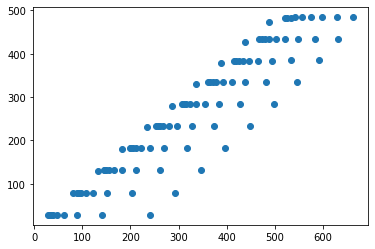

In [140]:
plt.scatter(m_x2, m_x1)

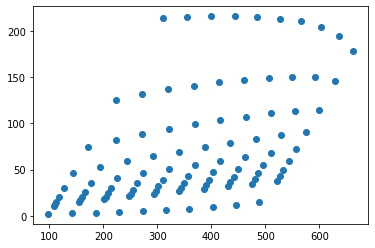

In [45]:
plt.scatter(m_x2, y)

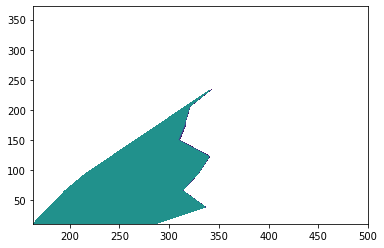

In [22]:
comb = np.array(br_h) + np.array(br_Z)
sel = ~np.isnan(comb)

plt.tricontourf(points[sel][:,1], points[sel][:,0], 
                np.array(comb)[sel],levels=np.linspace(0.99, 1.01, 100))

In [34]:
label = "BR(~chi_20 -> ~chi_10   Z )"
end = s.find(' # ' + label)
    
if end == -1:
    warnings.warn("Finding parameter %s failed. Returning NaN." % label)

else:
    start = s[:end].rfind("\n") + 2

    line = s[start:end]

    if line[0] == "#": line[0] = " "

    parind = len(line) - len(line.lstrip())
    parlen = line[parind:].find(" ")

    ind_val = len(line) - len(line[parind+parlen:].lstrip())

In [35]:
line

'    7.33361681E-02    2     1000022        23  '

In [38]:
parlen

14

In [37]:
float(line[parind:parind+parlen])

0.0733361681

In [28]:
ind_val

22

In [24]:
float(line[ind_val:])

ValueError: could not convert string to float: '2     1000022        23  '